In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

2025-06-20 21:22:56.376392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750454576.588536      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750454576.649158      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Load & preprocess data

In [3]:
train = pd.read_parquet("/kaggle/input/unmw-nb15/UNSW_NB15_training-set.parquet")
test = pd.read_parquet("/kaggle/input/unmw-nb15/UNSW_NB15_testing-set.parquet")
df = pd.concat([train, test])
df = df.drop(columns=['id', 'attack_cat'], errors='ignore')
# Encoding categorical columns to numerical
cat_cols = ['proto', 'service', 'state']
for col in cat_cols:
    df[col] = pd.factorize(df[col])[0]

X = df.drop('label', axis=1)
y = df['label']

# Standardizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

Define Encoder model

In [4]:
def build_encoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='swish')(inputs)
    x = layers.Dense(128, activation='swish')(x)
    projection = layers.Dense(64)(x)  # Projection head for contrastive learning
    return models.Model(inputs, projection)

Define Augmentation function

In [5]:
def augment_batch(X):
    mask = (np.random.rand(*X.shape) > 0.15).astype(np.float32)
    noise = np.random.normal(0, 0.05, size=X.shape).astype(np.float32)
    return X * mask + noise

Training & Evaluation

In [6]:
ratios = [(10,90), (20,80), (30,70), (40,60), (50,50), (60,40), (70,30), (80,20), (90,10)]
all_results = []

for train_pct, test_pct in ratios:
    print(f"\n--- Training with train:test = {train_pct}:{test_pct} ---")
    
    # Split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X.values.astype(np.float32), y.values,
        test_size=test_pct/100,
        stratify=y,
        random_state=42
    )
    
    # Initialize the encoder
    encoder = build_encoder(X_train.shape[1])
    optimizer = tf.keras.optimizers.Adam(3e-4)
    
    batch_size = 512
    epochs = 20
    num_samples = X_train.shape[0]
    
    # Training loop
    for epoch in range(epochs):
        idx = np.random.permutation(num_samples)
        X_shuffled = X_train[idx]
        for i in range(0, num_samples, batch_size):
            batch = X_shuffled[i:i+batch_size]
            if batch.shape[0] < 2:
                continue
            x_q = augment_batch(batch)
            x_k = augment_batch(batch)
            with tf.GradientTape() as tape:
                z_q = encoder(x_q, training=True)
                z_k = encoder(x_k, training=True)
                loss = tf.reduce_mean(tf.square(z_q - z_k))  # Using MSE as loss
            grads = tape.gradient(loss, encoder.trainable_weights)
            optimizer.apply_gradients(zip(grads, encoder.trainable_weights))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy():.4f}")
    
    # Step 4.1: Extract SSL features
    X_train_ssl = encoder.predict(X_train)
    X_test_ssl = encoder.predict(X_test)
    
    # Step 4.2: Train RandomForest on SSL features
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    rf.fit(X_train_ssl, y_train)
    y_pred = rf.predict(X_test_ssl)
    
    # Step 4.3: Classification report and store results
    report = classification_report(y_test, y_pred, output_dict=True)
    acc = report['accuracy']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    
    all_results.append({
        'train_pct': train_pct,
        'test_pct': test_pct,
        'accuracy': acc,
        'f1_class_0': f1_0,
        'f1_class_1': f1_1
    })
    
    print(f"Accuracy: {acc:.4f}, F1 Class 0: {f1_0:.4f}, F1 Class 1: {f1_1:.4f}")


# Save results 
results_df = pd.DataFrame(all_results)
results_df.to_csv('ssl_rf_results_all_epochs.csv', index=False)
print("\nSaved results to 'ssl_rf_results_all_epochs.csv'")


--- Training with train:test = 10:90 ---


I0000 00:00:1750454615.321233      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750454615.321955      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/20, Loss: 0.0022
Epoch 2/20, Loss: 0.0008
Epoch 3/20, Loss: 0.0004
Epoch 4/20, Loss: 0.0017
Epoch 5/20, Loss: 0.0003
Epoch 6/20, Loss: 0.0002
Epoch 7/20, Loss: 0.0001
Epoch 8/20, Loss: 0.0002
Epoch 9/20, Loss: 0.0002
Epoch 10/20, Loss: 0.0003
Epoch 11/20, Loss: 0.0001
Epoch 12/20, Loss: 0.0002
Epoch 13/20, Loss: 0.0001
Epoch 14/20, Loss: 0.0001
Epoch 15/20, Loss: 0.0001
Epoch 16/20, Loss: 0.0001
Epoch 17/20, Loss: 0.0001
Epoch 18/20, Loss: 0.0001
Epoch 19/20, Loss: 0.0001
Epoch 20/20, Loss: 0.0001


I0000 00:00:1750454664.410427     113 service.cc:148] XLA service 0x7a5dd8005cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750454664.411036     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750454664.411059     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750454664.486732     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


128/806 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

I0000 00:00:1750454664.769144     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


806/806 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.9052, F1 Class 0: 0.8628, F1 Class 1: 0.9276

--- Training with train:test = 20:80 ---
Epoch 1/20, Loss: 0.0011
Epoch 2/20, Loss: 0.0017
Epoch 3/20, Loss: 0.0012
Epoch 4/20, Loss: 0.0002
Epoch 5/20, Loss: 0.0002
Epoch 6/20, Loss: 0.0001
Epoch 7/20, Loss: 0.0001
Epoch 8/20, Loss: 0.0002
Epoch 9/20, Loss: 0.0005
Epoch 10/20, Loss: 0.0002
Epoch 11/20, Loss: 0.0001
Epoch 12/20, Loss: 0.0001
Epoch 13/20, Loss: 0.0002
Epoch 14/20, Loss: 0.0001
Epoch 15/20, Loss: 0.0001
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0000
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000
1611/1611 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Accuracy: 0.9089, F1 Class 0: 0.8691, F1 Class 1: 0.9301

--- Training with train:test = 30:70 ---
Epoch 1/20, Loss: 0.0054
Epoch 2/20, Loss: 0.0005
Epoch 3/20, Loss: 0.0002
Epoch 4/20, Loss: 0.0001
Epoch 5/20, Loss: 0.0

Visualization

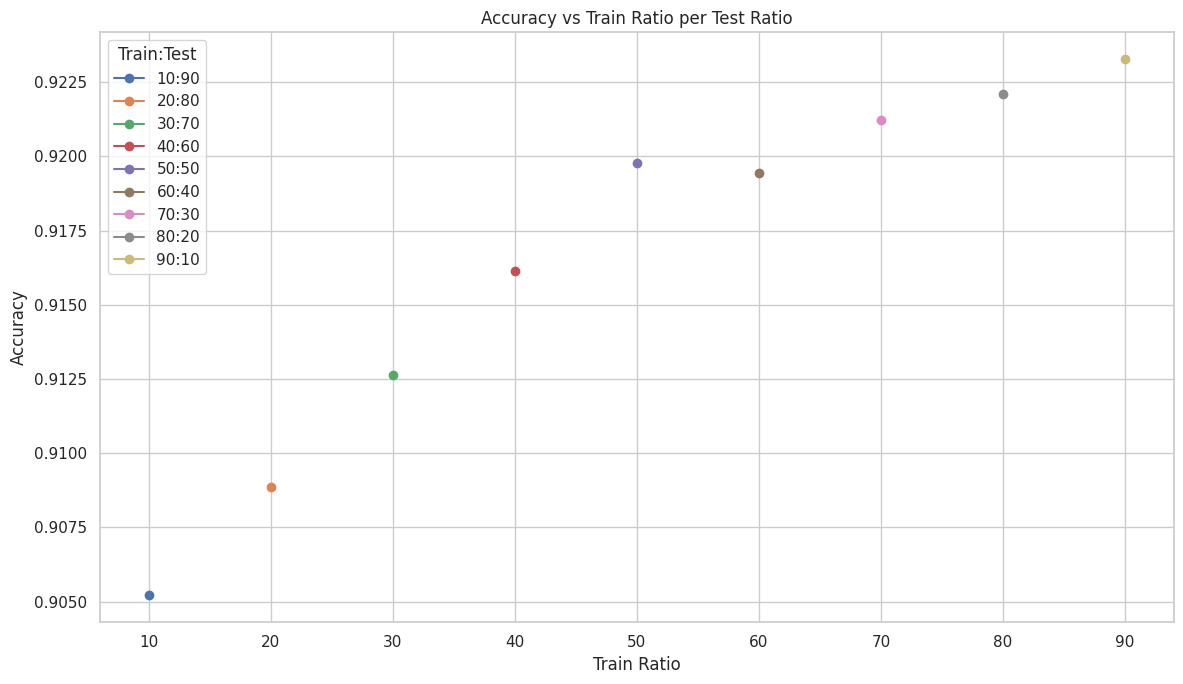

In [9]:
import seaborn as sns
sns.set(style="whitegrid")
ratios_unique = results_df[['train_pct', 'test_pct']].drop_duplicates()

# Accuracy vs Epoch
plt.figure(figsize=(12, 7))
for _, row in ratios_unique.iterrows():
    subset = results_df[
        (results_df['train_pct'] == row['train_pct']) & 
        (results_df['test_pct'] == row['test_pct'])
    ]
    label = f"{int(row['train_pct'])}:{int(row['test_pct'])}"
    plt.plot(subset['train_pct'], subset['accuracy'], marker='o', label=label)
plt.title("Accuracy vs Train Ratio per Test Ratio")
plt.xlabel("Train Ratio")
plt.ylabel("Accuracy")
plt.legend(title="Train:Test")
plt.tight_layout()
plt.show()

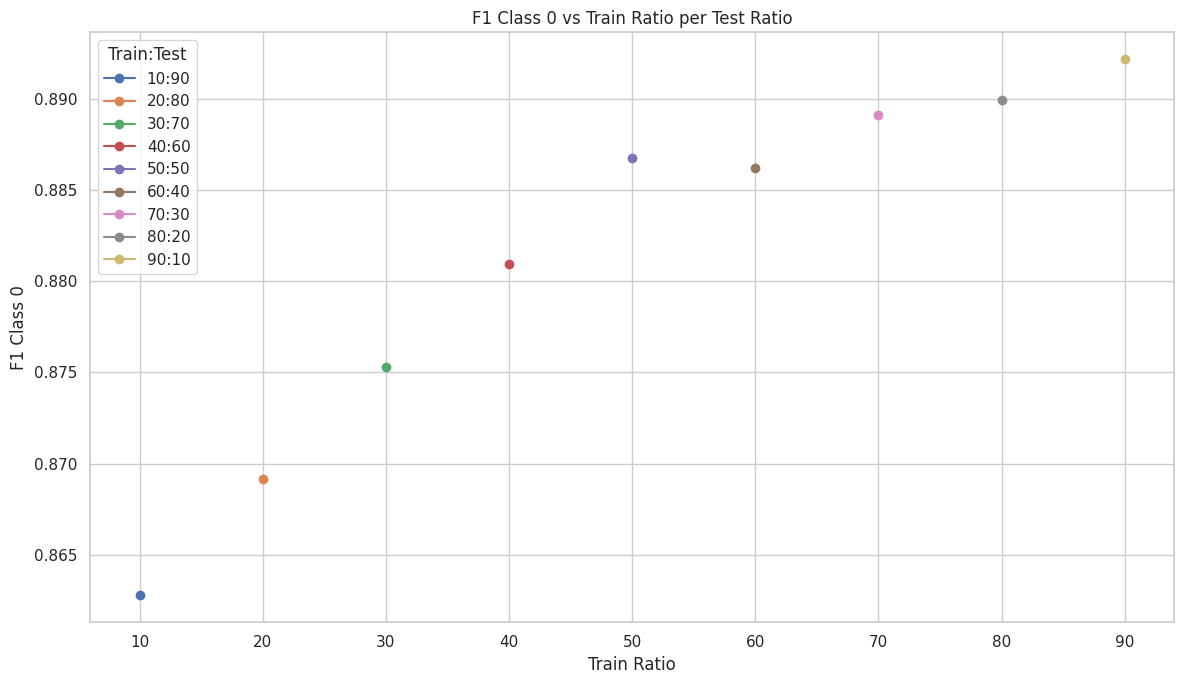

In [10]:
# Loss vs Epoch
plt.figure(figsize=(12, 7))
for _, row in ratios_unique.iterrows():
    subset = results_df[
        (results_df['train_pct'] == row['train_pct']) & 
        (results_df['test_pct'] == row['test_pct'])
    ]
    label = f"{int(row['train_pct'])}:{int(row['test_pct'])}"
    plt.plot(subset['train_pct'], subset['f1_class_0'], marker='o', label=label)
plt.title("F1 Class 0 vs Train Ratio per Test Ratio")
plt.xlabel("Train Ratio")
plt.ylabel("F1 Class 0")
plt.legend(title="Train:Test")
plt.tight_layout()
plt.show()